# 0. Import Libraries

In [ ]:
%pip install pandas
%pip install matplotlib

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.io import savemat
import math

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import time

In [2]:
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

# 1. Define Something in Advance

In [3]:
def U(x):
    return np.exp(-x)*np.sin(m*np.pi*x**2)

# 2. Initialize the Grid

In [4]:
x_domain = np.linspace(0, np.pi, 200)
delta = x_domain[1] - x_domain[0]

# 3. Define Physical Info.

    suppose: x = x[0]; u_x = x[1]; dudx = x[2]; du2dx = x[3]

In [5]:
governing_equation_components = []
governing_equation_components.append(Lambda(lambda x: l*x[2]))
governing_equation_components.append(Lambda(lambda x: g*tf.sin(x[2])))
governing_equation_components.append(Lambda(lambda x: x[1]))

In [6]:
governing_equation_mask = x_domain*0 + 1
governing_equation_mask[0] = 0
governing_equation_mask[-1] = 0

In [7]:
l = 1
g = 1
m = 1
fx = governing_equation_mask*(
           l*(2*m*np.pi*x_domain*np.exp(-x_domain)*np.cos(m*np.pi*x_domain**2)-np.exp(-x_domain)*np.sin(m*np.pi*x_domain**2)) + 
           g*np.sin(2*m*np.pi*x_domain*np.exp(-x_domain)*np.cos(m*np.pi*x_domain**2)-np.exp(-x_domain)*np.sin(m*np.pi*x_domain**2)) + 
           np.exp(-x_domain)*np.sin(m*np.pi*x_domain**2)    )

In [8]:
estimate_equation_form = False
equation_component_combination = [1.0,1.0,1.0]

# 4. Define the Observations

    suppose: x = x[0]; u_x = x[1]; dudx = x[2]; du2dx = x[3]

In [9]:
observation_components = []
observation_components.append(Lambda(lambda x: x[1]))
observation_components.append(Lambda(lambda x: x[2]))
observation_components.append(Lambda(lambda x: x[3]))

    format: [x,combination,value]

In [10]:
observation_data = []
observation_data.append([0,[1,0,0],U(0)])

# 5. Define PICN

In [11]:
def gradient_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[-1.0/(delta)]],[[1.0/(delta)]]], dtype=dtype)

In [12]:
def gradient_2_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[1.0/(delta**2)]],[[-2.0/(delta**2)]],[[1.0/(delta**2)]]], dtype=dtype)

In [13]:
inputs = [keras.layers.Input(shape=(1,1)),keras.layers.Input(shape=(len(x_domain),1))]

hidden_field = keras.layers.Conv1DTranspose(filters=1, 
                                            kernel_size=len(x_domain)+4, 
                                            activation='linear')(inputs[0])
coordinates = inputs[1]
field = keras.layers.Conv1D(filters=1, 
                            kernel_size=3, 
                            padding='valid', 
                            activation='linear')(hidden_field)
gradient_field = keras.layers.Conv1D(filters=1, 
                                     kernel_size=2, 
                                     padding='valid',
                                     use_bias=False,
                                     trainable=False,
                                     kernel_initializer=gradient_kernal_init)(field)
gradient_2_field = keras.layers.Conv1D(filters=1, 
                                       kernel_size=3, 
                                       padding='valid',
                                       use_bias=False,
                                       trainable=False,
                                       kernel_initializer=gradient_2_kernal_init)(field)
phycial_fields = [coordinates,field[:,1:-1,:],gradient_field[:,1:,:],gradient_2_field]

In [14]:
if estimate_equation_form==True:
    tf_governing_equation_components = [component(phycial_fields) for component in governing_equation_components]
    concat_equation_components = Lambda(lambda x: tf.concat(x,axis=-1))(tf_governing_equation_components)
    governing_equation = keras.layers.Conv1D(filters=1, 
                                             kernel_size=1, 
                                             padding='valid',
                                             use_bias=False)(concat_equation_components)
else:
    tf_weighted_governing_equation_components = [weight*component(phycial_fields) for [weight,component] in zip(equation_component_combination,governing_equation_components)]
    concat_weighted_equation_components = Lambda(lambda x: tf.concat(x,axis=-1))(tf_weighted_governing_equation_components)
    governing_equation = Lambda(lambda x: tf.reduce_sum(x,axis=-1,keepdims=True))(concat_weighted_equation_components)

In [15]:
tf_observation_components = [component(phycial_fields) for component in observation_components]
observation_list = []
for data in observation_data:
    if data[0] <= x_domain[0]:
        left_x_position_index = 0
        right_x_position_index = 1
        left_x_position_weight = 1
        right_x_position_weight = 0
    elif data[0] >= x_domain[-1]:
        left_x_position_index = -2
        right_x_position_index = -1
        left_x_position_weight = 0
        right_x_position_weight = 1
    else:
        left_x_position_index = int(np.round((data[0] - x_domain[0])/delta))
        right_x_position_index = int(np.round(left_x_position_index + 1))
        left_x_position_weight = 1-(data[0] - (x_domain[0]+delta*left_x_position_index))/delta
        right_x_position_weight = 1-left_x_position_weight
        
    left_position_observation_components = [component[:,left_x_position_index,:] for component in tf_observation_components]
    right_position_observation_components = [component[:,right_x_position_index,:] for component in tf_observation_components]
    
    concat_weighted_left_position_observation_components = Lambda(lambda x: tf.concat(x,axis=-1))([weight*component for [weight,component] in zip(data[1],left_position_observation_components)])
    concat_weighted_right_position_observation_components = Lambda(lambda x: tf.concat(x,axis=-1))([weight*component for [weight,component] in zip(data[1],right_position_observation_components)])
    
    left_observation = Lambda(lambda x: tf.reduce_sum(x,axis=-1,keepdims=True))(concat_weighted_left_position_observation_components)
    right_observation = Lambda(lambda x: tf.reduce_sum(x,axis=-1,keepdims=True))(concat_weighted_right_position_observation_components)
    
    observation_list.append(left_x_position_weight*left_observation + right_x_position_weight*right_observation)
    
observations = Lambda(lambda x: tf.concat(x,axis=-1))(observation_list)

In [16]:
pde_model = keras.Model(inputs=inputs, outputs=phycial_fields)
pde_model_train = keras.Model(inputs=inputs, outputs=[governing_equation,observations])

In [17]:
def model_print_functoin(s):
    with open('model_summary.txt','a') as f:
        print(s, file=f)

pde_model.summary(print_fn=model_print_functoin)
pde_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 1)]               0         []                            
                                                                                                  
 conv1d_transpose (Conv1DTr  (None, 204, 1)               205       ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 conv1d (Conv1D)             (None, 202, 1)               4         ['conv1d_transpose[0][0]']    
                                                                                                  
 conv1d_1 (Conv1D)           (None, 201, 1)               2         ['conv1d[0][0]']          

In [18]:
pde_model_train.input

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 200, 1) dtype=float32 (created by layer 'input_2')>]

In [19]:
pde_model_train.output

[<KerasTensor: shape=(None, 200, 1) dtype=float32 (created by layer 'lambda_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lambda_12')>]

# 6. Prepare the Training Data

In [20]:
unit_constant = np.asarray([[[1.0]]],dtype=np.float32)
training_input_data_0 = np.repeat(unit_constant, 1, axis=0)
print(training_input_data_0.shape)

(1, 1, 1)


In [21]:
training_input_data_1 = np.expand_dims(x_domain.astype(np.float32),axis=[0,-1])
print(training_input_data_1.shape)

(1, 200, 1)


In [22]:
training_label_data_0 = np.expand_dims(fx,axis=(0,-1))
print(training_label_data_0.shape)

(1, 200, 1)


In [23]:
training_label_data_1 = np.expand_dims(np.asarray([data[2] for data in observation_data]),axis=[0])
print(training_label_data_1.shape)

(1, 1)


In [24]:
training_input_data = [training_input_data_0,training_input_data_1]
training_label_data = [training_label_data_0,training_label_data_1]

# 6. Train the Model

In [25]:
pde_model_train.compile(optimizer=keras.optimizers.Adam(), loss="mse")
pde_model_train.save_weights('picn_initial_weights.h5')
temp_history = pde_model_train.fit(x=training_input_data, y=training_label_data, epochs=1, verbose=0)
history_keys = []
for key in temp_history.history.keys():
    history_keys.append(key)
print(history_keys)

['loss', 'lambda_7_loss', 'lambda_12_loss']


In [26]:
def record_predictions():
    [_,ux, dudx, d2udx2] = pde_model.predict(training_input_data)
    ux_list.append(ux[0,:,0])
    dudx_list.append(dudx[0,:,0])
    d2udx2_list.append(d2udx2[0,:,0])

class Per_X_Epoch_Record(tf.keras.callbacks.Callback):
    def __init__(self, record_interval, verbose=1):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.total_loss = history_keys[0]
        self.domain_loss = history_keys[1]
        self.bdc_loss = history_keys[2]
        self.previous_total_loss = 9999999
        self.record_interval = record_interval;
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch%self.record_interval == 0:
            
            current_total_loss = logs.get(self.total_loss)
            current_domain_loss = logs.get(self.domain_loss)
            current_bdc_loss = logs.get(self.bdc_loss)
            
            epoch_number_list.append(epoch)
            total_loss_list.append(current_total_loss)
            domain_loss_list.append(current_domain_loss)
            boundary_loss_list.append(current_bdc_loss)
        
            if current_total_loss < self.previous_total_loss:
                self.previous_total_loss = current_total_loss
                pde_model_train.save_weights('picn_best_weights.h5')
            
            if self.verbose > 0:
                print("epoch: {:10.5f} | total_loss: {:10.5f} | domain_loss: {:10.5f} | bdc_loss: {:10.5f}".format(epoch,current_total_loss,current_domain_loss,current_bdc_loss))
        
            # evaluate the errors in f-domain
            record_predictions()

In [27]:
callbacks = [
    Per_X_Epoch_Record(record_interval=200,verbose=1),
]

In [28]:
epoch_number_list = []
total_loss_list = []
domain_loss_list = []
boundary_loss_list = []
ux_list = []
dudx_list = []
d2udx2_list = []
pde_model_train.load_weights('picn_initial_weights.h5')
pde_model_train.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse", loss_weights = [0.1, 0.9])

# Record the training time cost
start = time.time()

# Training
pde_model_train.fit(x=training_input_data, 
                    y=training_label_data, 
                    epochs=20000, verbose=0,
                    callbacks=callbacks)

# Record the training time cost
end = time.time()
print("Training time cost: {:10.5f} seconds".format(end - start))
time_costs_text_file = open("time_costs.txt", "w")
time_costs_text_file.write("Training time cost: {:10.5f} seconds".format(end - start))
time_costs_text_file.close()

# Load the best weights
pde_model_train.load_weights('picn_best_weights.h5')

epoch:    0.00000 | total_loss:    1.29920 | domain_loss:   12.97040 | bdc_loss:    0.00240
1/1 [==============================] - 0s 66ms/step
epoch:  200.00000 | total_loss:    0.07145 | domain_loss:    0.71442 | bdc_loss:    0.00001
1/1 [==============================] - 0s 12ms/step
epoch:  400.00000 | total_loss:    0.03100 | domain_loss:    0.30994 | bdc_loss:    0.00000
1/1 [==============================] - 0s 11ms/step
epoch:  600.00000 | total_loss:    0.03025 | domain_loss:    0.30246 | bdc_loss:    0.00000
1/1 [==============================] - 0s 9ms/step
epoch:  800.00000 | total_loss:    0.02988 | domain_loss:    0.29883 | bdc_loss:    0.00000
1/1 [==============================] - 0s 10ms/step
epoch: 1000.00000 | total_loss:    0.00065 | domain_loss:    0.00654 | bdc_loss:    0.00000
1/1 [==============================] - 0s 10ms/step
epoch: 1200.00000 | total_loss:    0.00048 | domain_loss:    0.00481 | bdc_loss:    0.00000
1/1 [==============================] - 0s 9ms

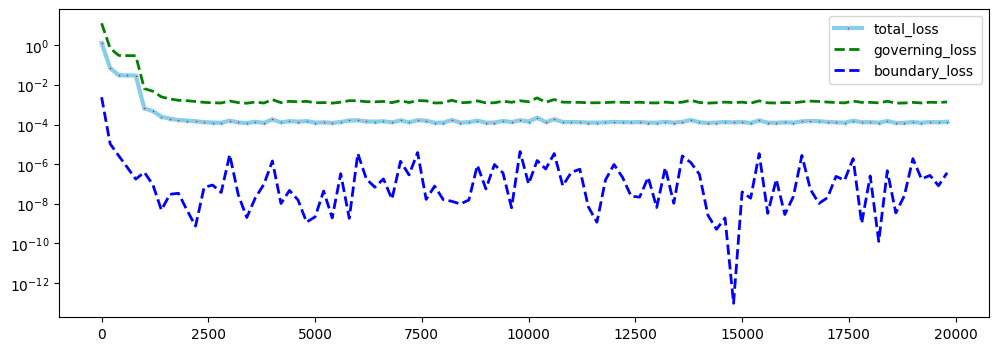

In [29]:
df=pd.DataFrame({'epoch': epoch_number_list, 
                 'total_loss': total_loss_list, 
                 'governing_loss': domain_loss_list, 
                 'boundary_loss': boundary_loss_list})

plt.figure(figsize=(12, 4))
plt.plot( 'epoch', 'total_loss', data=df, marker='o', markerfacecolor='red', markersize=2, color='skyblue', linewidth=3)
plt.plot( 'epoch', 'governing_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.plot( 'epoch', 'boundary_loss', data=df, marker='', color='blue', linewidth=2, linestyle='dashed')
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [30]:
[_, u_pred, dudx_pred, d2udx2_pred] = pde_model.predict(training_input_data)

1/1 [==============================] - 0s 12ms/step


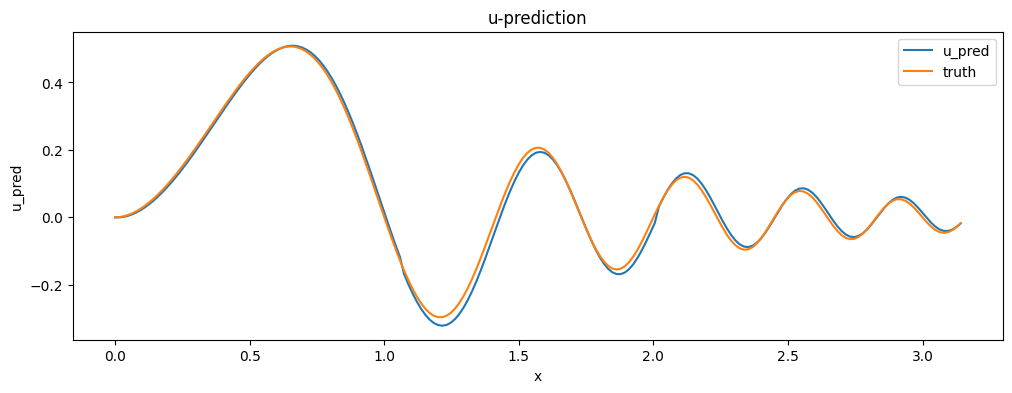

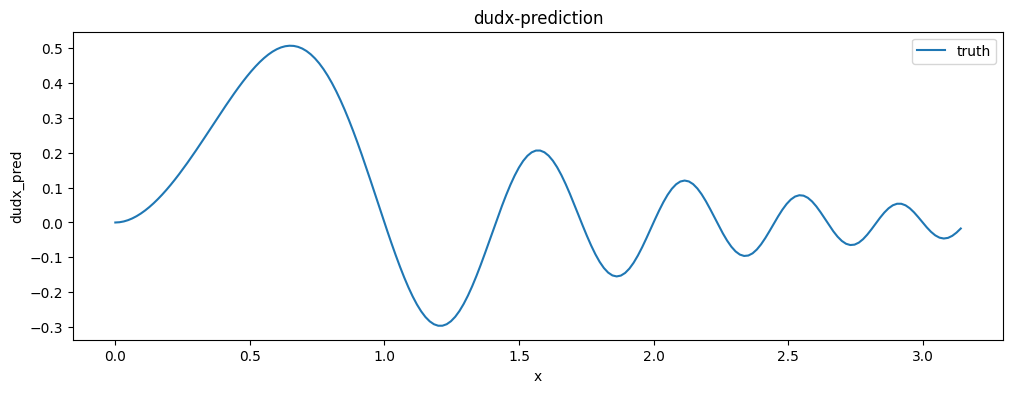

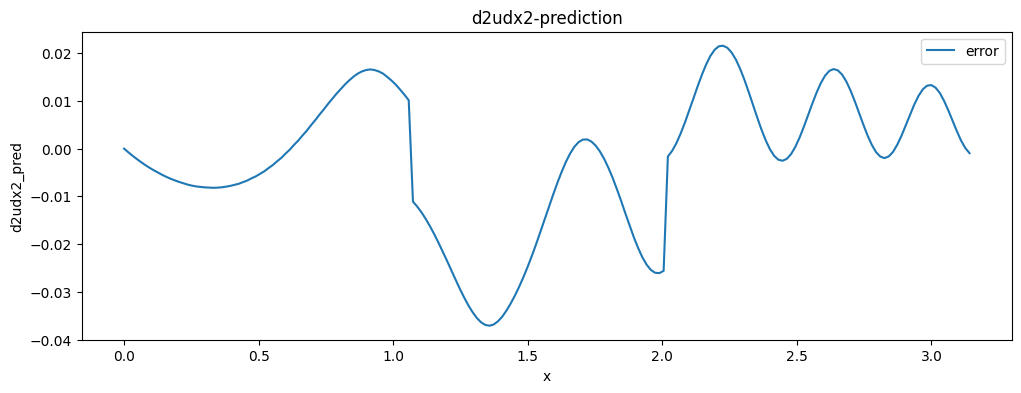

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(x_domain,u_pred[0,:,0],label='u_pred')
plt.plot(x_domain,U(x_domain),label='truth')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.title('u-prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x_domain,U(x_domain),label='truth')
plt.xlabel('x')
plt.ylabel('dudx_pred')
plt.title('dudx-prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x_domain,u_pred[0,:,0]-U(x_domain),label='error')
plt.xlabel('x')
plt.ylabel('d2udx2_pred')
plt.title('d2udx2-prediction')
plt.legend()
plt.show()

# 7. Save the Process Data

In [32]:
picn_process_data = {'x_domain':x_domain,
                     'epoch_number_list':np.asarray(epoch_number_list),
                     'total_loss_list':np.asarray(total_loss_list),
                     'domain_loss_list':np.asarray(domain_loss_list),
                     'boundary_loss_list':np.asarray(boundary_loss_list),
                     'ux_list':np.vstack(ux_list),
                     'dudx_list':np.vstack(dudx_list),
                     'd2udx2_list':np.vstack(d2udx2_list)}
savemat('picn_process_data.mat', picn_process_data)